**Variational Auto-Encoders**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import *
from tqdm import tqdm

## Data Preparation

### Data Prep 1

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

11490434/11490434 [==============================] - 0s 0us/step


(70000, 28, 28, 1)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

In [4]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

### Data Prep 2

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

print(mnist_digits.shape)

# Create an ImageDataGenerator for data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
)

x_train = train_gen.flow(
    mnist_digits,
    shuffle=True,
    batch_size=128,
)

(70000, 28, 28, 1)


## Modeling VAES

In [6]:
LATENT_DIM = 2
BATCH_SIZE = 128

### Sampling

In [7]:
class Sampling(Layer):

    def call(self, inputs):
        mean, logvar = inputs
        return mean + tf.math.exp(0.5*logvar)*tf.random.normal(shape = tf.shape((BATCH_SIZE, LATENT_DIM)))

## Encoder

In [8]:
def Encoder(latent_dim = LATENT_DIM):

    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), strides = 2, padding="same")(inputs)
    x = Conv2D(64, (3, 3), strides  = 2, padding="same")(x)

    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    mean = Dense(LATENT_DIM,)(x)
    log_var = Dense(LATENT_DIM, )(x)

    z = Sampling()([mean, log_var])

    model = Model(inputs=inputs, outputs=[z,mean,log_var], name='VAE-Encoder')
    return model

Encoder_model = Encoder()
Encoder_model.summary()

Model: "VAE-Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                        

#### Testing Variational Encoder

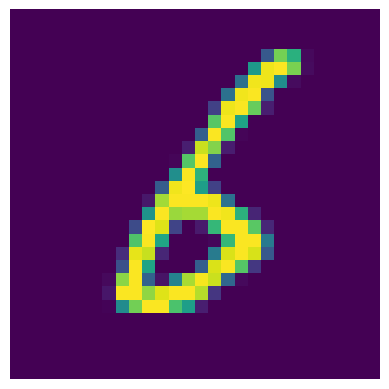

In [9]:
teste = x_train[0][0]
plt.imshow(teste)
plt.axis('off')
plt.show()

In [10]:
teste = tf.expand_dims(teste, axis = 0)
teste.shape

TensorShape([1, 28, 28, 1])

In [11]:
encoded_image = Encoder_model.predict(teste)
print('Z : ' + str(encoded_image[0]))
print('Mean : ' + str(encoded_image[1]))
print('Log_Var : ' + str(encoded_image[2]))


1/1 [==============================] - 0s 155ms/step
Z : [[-0.7930822 -0.4755938]]
Mean : [[-0.01444981 -0.28321752]]
Log_Var : [[-0.02678208  0.08242633]]


## Decoder

In [12]:
def Decoder():

    latent_inputs = Input(shape=(LATENT_DIM,))
    x = Dense(7*7*64, activation='relu')(latent_inputs)
    x = Reshape((7,7,64))(x)

    x = Conv2DTranspose(64,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(32,(3,3), strides= 2, padding="same")(x)
    x = Conv2DTranspose(1,(3,3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=latent_inputs, outputs=x, name='VAE-Decoder')
    return model

Decoder_model = Decoder()
Decoder_model.summary()

Model: "VAE-Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         

#### Testing Variational Decoder

1/1 [==============================] - 0s 94ms/step


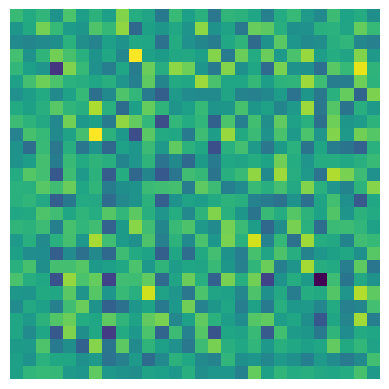

In [13]:
#Zero Shot

Dencoded_image = Decoder_model.predict(encoded_image[0])
plt.imshow(Dencoded_image[0])
plt.axis('off')
plt.show()

## VAE Full Model

In [14]:
def VAE():
    vae_inputs = Input(shape=(28, 28, 1))
    z, _, _ = Encoder_model(vae_inputs)
    outputs = Decoder_model(z)

    vae_model = Model(vae_inputs, outputs, name='VAE')
    return vae_model

VAE_model = VAE()
VAE_model.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 VAE-Encoder (Functional)    [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 VAE-Decoder (Functional)    (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [15]:
def customized_loss(y_true, y_pred, mean, log_var):
    # Loss que tenta aproximar os valores de cada pixel do correto
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2)))

    # Loss que tenta aproximar os valores da média e do desvio padrão dos pixels
    # Para isso, utiliza o logaritmo natural para evitar problemas com números negativos
    regression_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.square(mean)-tf.exp(log_var)),axis = 1))

    return reconstruction_loss + regression_loss

In [16]:
# class VAE_Model(Model):
#     def __init__(self, encoder, decoder):
#         super(VAE_Model, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.loss_tracker = tf.keras.metrics.Mean(name="loss")

#     @property
#     def metrics(self):
#         return [self.loss_tracker.result()]

#     def train_step(self, data):
#         with tf.GradientTape() as recorder:
#             z, mean, log_var = self.encoder(data)
#             y_pred = self.decoder(z)
#             loss = customized_loss(data, y_pred, mean, log_var)

#         gradients = recorder.gradient(loss, self.trainable_weights)
#         Adam(learning_rate = 0.0001).apply_gradients(zip(gradients, self.trainable_weights))

#         self.loss_tracker.update_state(loss)
#         return {'loss':self.loss_tracker.result()}


# vae_model = VAE_Model(Encoder_model, Decoder_model)
# vae_model.compile(optimizer=Adam(learning_rate = 0.0001))
# vae_model.fit(train_dataset, epochs=20)


In [17]:
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = Encoder_model(x_batch)
        y_pred = Decoder_model(z)
        loss = customized_loss(x_batch, y_pred, mean, log_var)

    gradients = recorder.gradient(loss, VAE_model.trainable_weights)
    Adam(learning_rate = 0.0001).apply_gradients(zip(gradients, VAE_model.trainable_weights))
    return loss

In [18]:
def train(data, epochs):
    for epoch in tqdm(range(epochs)):
        print('Epoch: ',epoch+1)

        for step, x_batch in enumerate(data):
            loss = training_block(x_batch)
        print('Training Loss: ',loss.numpy())
        if loss < 160:
            break

In [19]:
train(train_dataset, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1


  5%|▌         | 1/20 [01:03<20:02, 63.28s/it]

Training Loss:  233.01433
Epoch:  2


 10%|█         | 2/20 [02:05<18:46, 62.58s/it]

Training Loss:  214.68022
Epoch:  3


 15%|█▌        | 3/20 [03:08<17:45, 62.66s/it]

Training Loss:  206.97383
Epoch:  4


 20%|██        | 4/20 [04:10<16:42, 62.67s/it]

Training Loss:  197.64885
Epoch:  5


 25%|██▌       | 5/20 [05:12<15:37, 62.48s/it]

Training Loss:  196.2174
Epoch:  6


 30%|███       | 6/20 [06:13<14:27, 61.94s/it]

Training Loss:  196.71953
Epoch:  7


 35%|███▌      | 7/20 [07:14<13:19, 61.50s/it]

Training Loss:  179.42311
Epoch:  8


 40%|████      | 8/20 [08:14<12:13, 61.16s/it]

Training Loss:  181.8867
Epoch:  9


 45%|████▌     | 9/20 [09:15<11:11, 61.02s/it]

Training Loss:  183.74036
Epoch:  10


 50%|█████     | 10/20 [10:16<10:10, 61.01s/it]

Training Loss:  176.55315
Epoch:  11


 55%|█████▌    | 11/20 [11:17<09:08, 60.91s/it]

Training Loss:  193.10898
Epoch:  12


 60%|██████    | 12/20 [12:17<08:04, 60.58s/it]

Training Loss:  169.41786
Epoch:  13


 65%|██████▌   | 13/20 [13:17<07:03, 60.46s/it]

Training Loss:  182.46013
Epoch:  14


 70%|███████   | 14/20 [14:17<06:01, 60.26s/it]

Training Loss:  178.74216
Epoch:  15


 75%|███████▌  | 15/20 [15:17<05:01, 60.30s/it]

Training Loss:  171.59421
Epoch:  16


 80%|████████  | 16/20 [16:17<04:00, 60.21s/it]

Training Loss:  168.56792
Epoch:  17


 85%|████████▌ | 17/20 [17:17<03:00, 60.21s/it]

Training Loss:  178.53806
Epoch:  18


 90%|█████████ | 18/20 [18:17<02:00, 60.06s/it]

Training Loss:  168.59972
Epoch:  19


 95%|█████████▌| 19/20 [19:17<01:00, 60.22s/it]

Training Loss:  174.90958
Epoch:  20


100%|██████████| 20/20 [20:18<00:00, 60.91s/it]

Training Loss:  176.92856


## Testing

In [20]:
scale=1
n=16

In [21]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

1/1 [==============================] - 0s 22ms/step


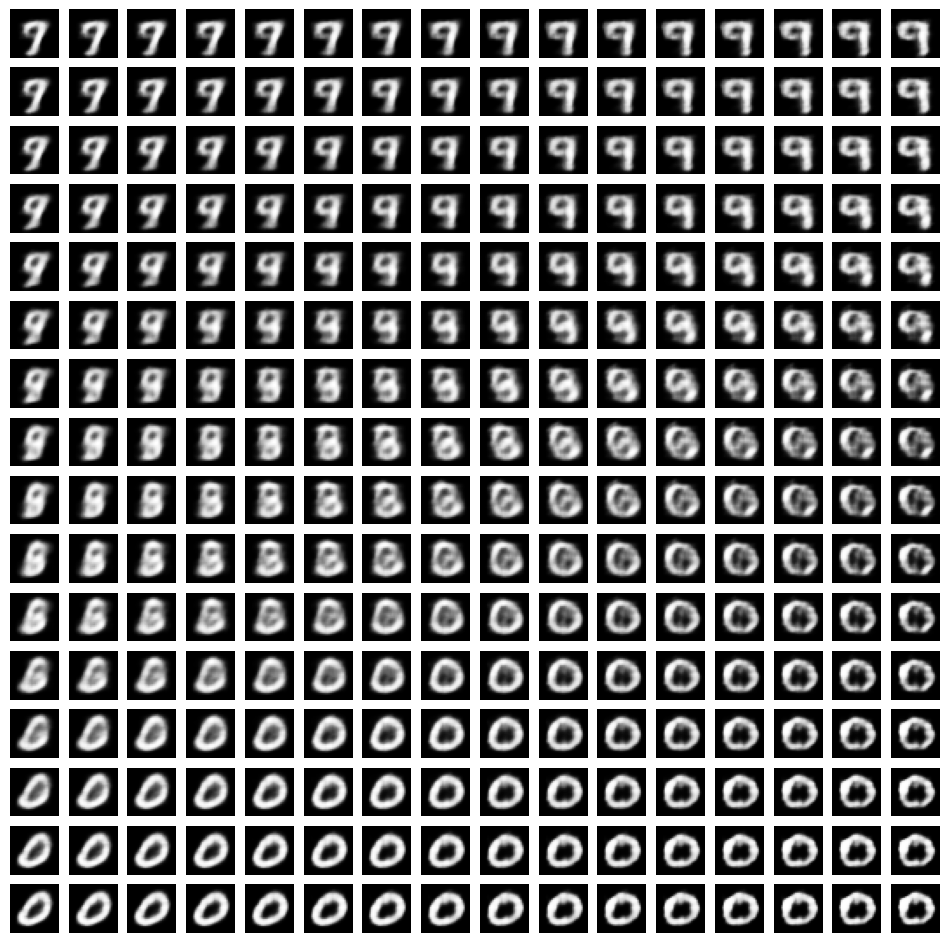

In [22]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=VAE_model.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [23]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train, -1).astype("float32") / 255

1875/1875 [==============================] - 5s 2ms/step


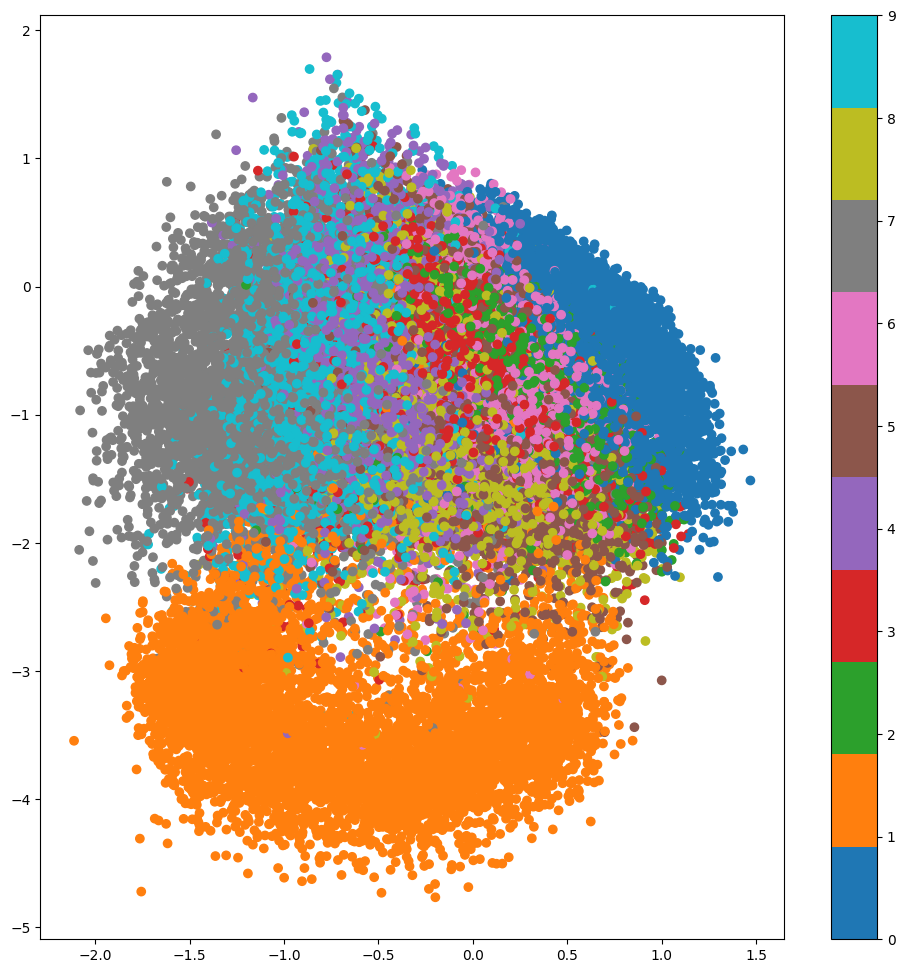

In [24]:
z, _, _ = VAE_model.layers[1].predict(mnist_digits)

plt.figure(figsize=(12, 12))
plt.scatter(z[:, 0], z[:, 1], c=y_train, cmap="tab10")
plt.colorbar()